<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 16px;">

### **Task I: Using ResNet as Pretrained Model as a Feature Extractor for  Remote Sensing based Image Classification**  
**Author: Ramesh Bhatta, CIS, RIT**  
**Github Repo: https://github.com/Bhatta6190/Machine-Learning-in-Remote-Sensing/tree/main/Deep-Learning**  

</div>

In [1]:
## Import libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [2]:
## Predefined plot preferences

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

In [3]:
## Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Import data

path = '/content/drive/... ... /Transfer-Learning/UCMerced_LandUse/Images' # Top data path
class_dirs = sorted([f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]) # list of all class directories


# Plot a sample from each 21 class
fig, axes = plt.subplots(3, 7, figsize=(15, 8))
fig.suptitle('Sample Classes')
for i, class_dir in enumerate(class_dirs):
  image_path = os.path.join(path, class_dir, os.listdir(os.path.join(path, class_dir))[20]) # get path for nth image from each class
  image = mpimg.imread(image_path)    # read the image

  # Plot the images
  ax = axes[i//7, i%7]
  ax.imshow(image)
  ax.set_title(class_dir)
  ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [5]:
## Step-1: Data preparation- Transformation

# Normalization using ImageNet mean and std
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),      # For each band
])

# Load the dataset
transformed_data = datasets.ImageFolder(root=path, transform=preprocess)      # Class indexing based on subfolders

# View the labels
print('Class vs Label:\n')
transformed_data.class_to_idx

Class vs Label:



{'agricultural': 0,
 'airplane': 1,
 'baseballdiamond': 2,
 'beach': 3,
 'buildings': 4,
 'chaparral': 5,
 'denseresidential': 6,
 'forest': 7,
 'freeway': 8,
 'golfcourse': 9,
 'harbor': 10,
 'intersection': 11,
 'mediumresidential': 12,
 'mobilehomepark': 13,
 'overpass': 14,
 'parkinglot': 15,
 'river': 16,
 'runway': 17,
 'sparseresidential': 18,
 'storagetanks': 19,
 'tenniscourt': 20}

In [6]:
## Step-1 contd: Data preparation- Split data

# Dataset Split
train_size = int(0.7 * len(transformed_data))    # 70 % training set
val_size = int(0.15 * len(transformed_data))     # 15 % validation
test_size = len(transformed_data) - train_size - val_size  # 15 % test set

train_dataset, val_dataset, test_dataset = random_split(
    transformed_data, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Fixed seed
)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [7]:
## Step 2: Feature Extraction Using ResNet18 Model

# Load pretrained ResNet Model
model = models.resnet18(weights="IMAGENET1K_V1")

# Remove the final classification layer
model = nn.Sequential(*list(model.children())[:-1])  # Keeps features up to avgpool

"""
Notes:

  - model.children(): Returns all layers of ResNet18 as a list
  - [:-1]: Excludes the last layer (the 1000-class FC layer)
  - nn.Sequential: Rebuilds the model for feature extraction
  - for an input image (3, 224, 224), the output is now a 512 (Resnet18)-dimensional feature vector (instead of 1000-class logits)
  - output size: (batch_size, 512, 1, 1)
  - when using Resnet50 the the feature size will be 2048 in place of 512

"""

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Evaluation mode


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [8]:
## Feature Extraction

def get_features(dataloader, model):
    features = []
    labels = []

    with torch.no_grad():             # no gradient calculation
        for images, targets in dataloader:
            images = images.to(device)
            batch_features = model(images).squeeze()  # model(images): [B, 512, 1, 1] ---> model(images).squeeze(): [B, 512]
            features.append(batch_features.cpu().numpy())
            labels.append(targets.numpy())

    return np.concatenate(features), np.concatenate(labels)

# Extract features all data set
train_features, train_labels = get_features(train_loader, model)
val_features, val_labels = get_features(val_loader, model)
test_features, test_labels = get_features(test_loader, model)

In [9]:
train_features.shape

(1470, 512)

In [10]:
## training XGBoost classifier based on extracted features

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Train XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(train_features, train_labels)

# Predict on test set
test_preds = xgb.predict(test_features)

# Evaluate
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average="weighted")
recall = recall_score(test_labels, test_preds, average="weighted")
f1 = f1_score(test_labels, test_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8857
Precision: 0.8968
Recall: 0.8857
F1-Score: 0.8853


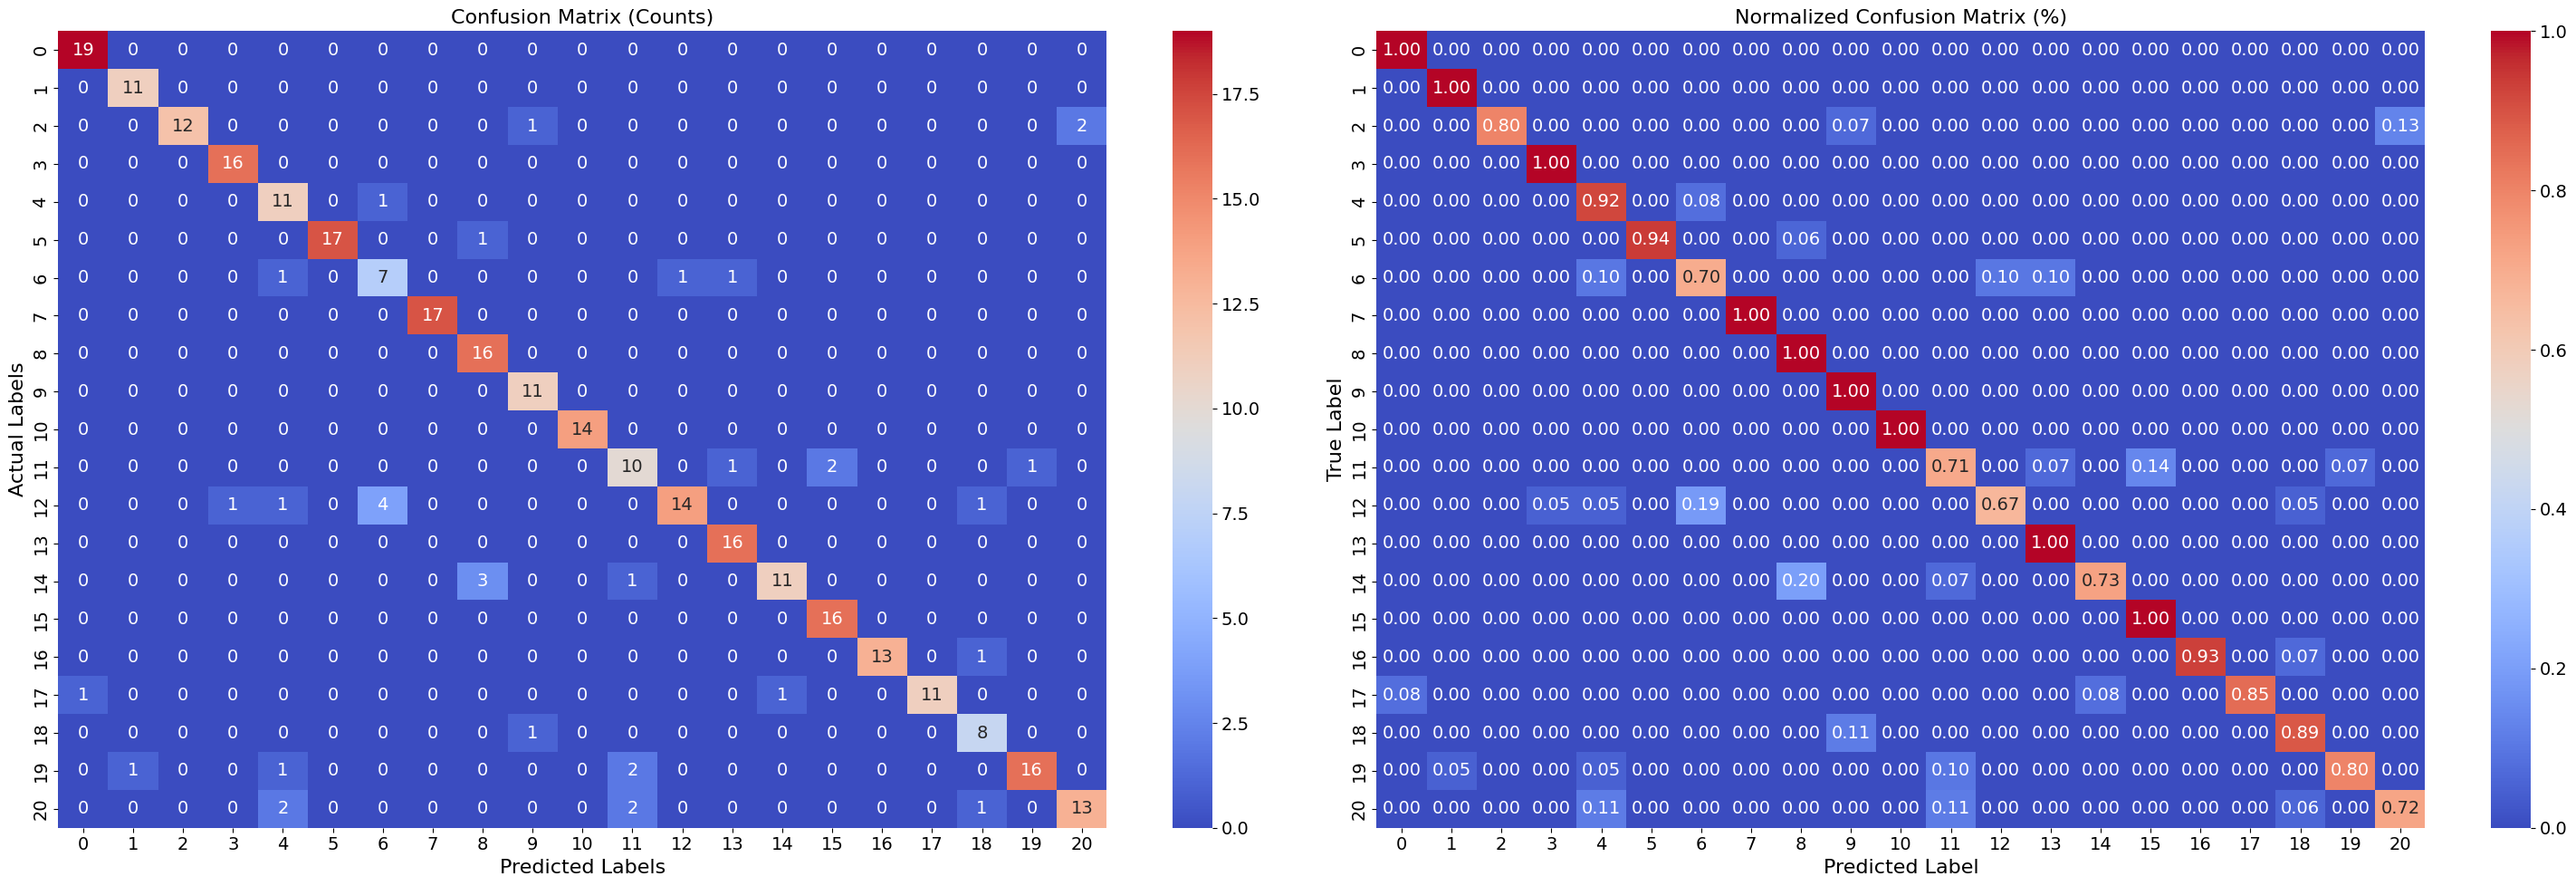

In [11]:
## Confusion Matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

# sample based confusion matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', ax=ax1)
ax1.set_title("Confusion Matrix (Counts)")
ax1.set_xlabel("Predicted Labels")
ax1.set_ylabel("Actual Labels")

# Normalized confusion matrix
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize w/ true labels
sns.heatmap(np.round(cm_normalized, 2), annot=True, fmt=".2f", cmap='coolwarm',
            vmin=0, vmax=1, ax=ax2)
ax2.set_title("Normalized Confusion Matrix (%)")
ax2.set_xlabel("Predicted Label")
ax2.set_ylabel("True Label")
plt.tight_layout()
plt.show()


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---
**Comments:** Using the 512 features extracted using ImageNet trained ResNet18 model to classify the UCMerced dataset we are able to obtain almost 89% classification accuracy, 90% precision and 89% recall scores. This is a pretty good outcome considering the fact that we didnt need to train the model with our limited dataset and used features from already trained dataset for classification. Most of the classes are predicted accurately with some notable confusion between class 6 ('denseresidential') vs class 12 ('mediumresidential') and class 8 ('freeway') vs class 14 ('overpass') as seen from the confusion matrix. These are due to similarity in their appearances and features. However the model is almost perfectly predicting classes with distinct differences like forest and airplanes.  

---
---

</div>


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 16px;">

### **Task II: Fine-tuning the Pretrained Model- Training Only the Head**  

</div>

In [12]:
## Modify the model

# Step 1: Modify the network

model = models.resnet18(weights="IMAGENET1K_V1")
num_classes = 21
num_ftrs = model.fc.in_features                 # 512 features for ResNet18 or 2048 for ResNet50
model.fc = nn.Linear(num_ftrs, num_classes)     # Replace final layer: 512 --> 21 features

In [13]:
model.fc

Linear(in_features=512, out_features=21, bias=True)

In [14]:
# Step 2: Freeze the Base Model

for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

for param in model.fc.parameters():
    param.requires_grad = True  # Unfreeze only the classification head


In [15]:
# Move model to GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
## Step 3: Training Setup

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)  # Only optimize the head
scheduler = ExponentialLR(optimizer, gamma=0.9)  # Optional LR decay

In [17]:
## Step 3 contd: Training the model

# Track losses and accuracy
train_losses, val_losses = [], []
best_val_loss = float('inf')
epochs = 25

# path to save best model
top_path = '/content/drive/... .../Transfer-Learning' 

# Training
for epoch in range(epochs):

    # Training loop
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # send input, labels to gpu
        optimizer.zero_grad()                                 # Zero gradients for every batch
        outputs = model(inputs)                               # Prediction for current batch
        loss = criterion(outputs, labels)                     # loss calculations
        loss.backward()                                       # back-propagation
        optimizer.step()                                      # Adjust learning weights
        running_loss += loss.item()                           # Total loss

    train_loss = running_loss / len(train_loader)             # Loss per batch
    train_losses.append(train_loss)

# Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), top_path + '/best_model_head_only.pth')

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/25 | Train Loss: 2.4962 | Val Loss: 1.8475
Epoch 2/25 | Train Loss: 1.4886 | Val Loss: 1.2127
Epoch 3/25 | Train Loss: 1.0229 | Val Loss: 0.9447
Epoch 4/25 | Train Loss: 0.7967 | Val Loss: 0.7819
Epoch 5/25 | Train Loss: 0.6607 | Val Loss: 0.6815
Epoch 6/25 | Train Loss: 0.5634 | Val Loss: 0.6157
Epoch 7/25 | Train Loss: 0.5092 | Val Loss: 0.5724
Epoch 8/25 | Train Loss: 0.4603 | Val Loss: 0.5316
Epoch 9/25 | Train Loss: 0.4325 | Val Loss: 0.5124
Epoch 10/25 | Train Loss: 0.3994 | Val Loss: 0.4918
Epoch 11/25 | Train Loss: 0.3731 | Val Loss: 0.4725
Epoch 12/25 | Train Loss: 0.3544 | Val Loss: 0.4562
Epoch 13/25 | Train Loss: 0.3410 | Val Loss: 0.4398
Epoch 14/25 | Train Loss: 0.3263 | Val Loss: 0.4338
Epoch 15/25 | Train Loss: 0.3193 | Val Loss: 0.4278
Epoch 16/25 | Train Loss: 0.3099 | Val Loss: 0.4199
Epoch 17/25 | Train Loss: 0.2969 | Val Loss: 0.4140
Epoch 18/25 | Train Loss: 0.3004 | Val Loss: 0.4063
Epoch 19/25 | Train Loss: 0.2898 | Val Loss: 0.4046
Epoch 20/25 | Train L

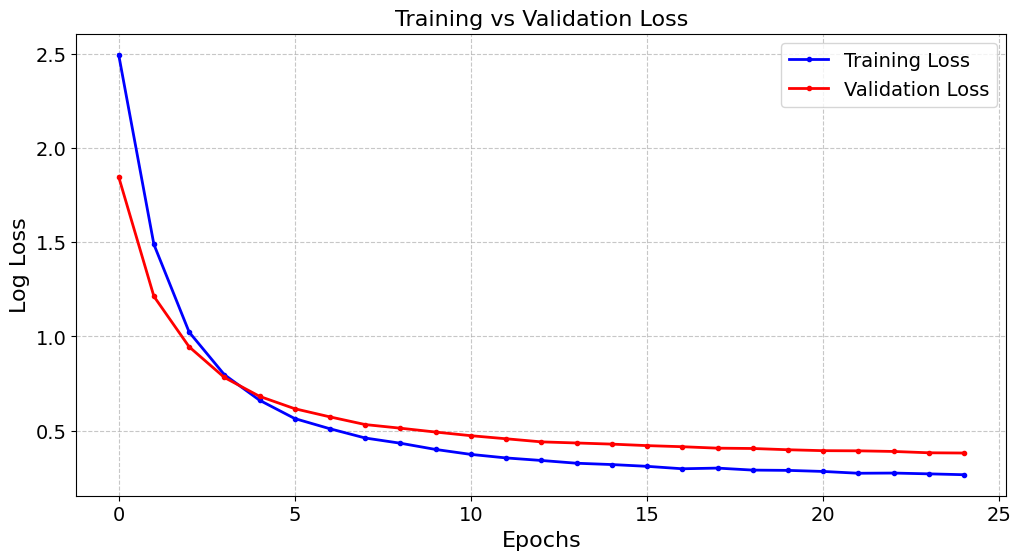

In [18]:
# Plot training/validation losses

# Loss curve plot

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2, marker = 'o', markersize = 3)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2, marker = 'o', markersize = 3)
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

In [19]:
# Load best model

model.load_state_dict(torch.load(top_path + '/best_model_head_only.pth'))
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.9079
Precision: 0.9194
Recall: 0.9079
F1-Score: 0.9098


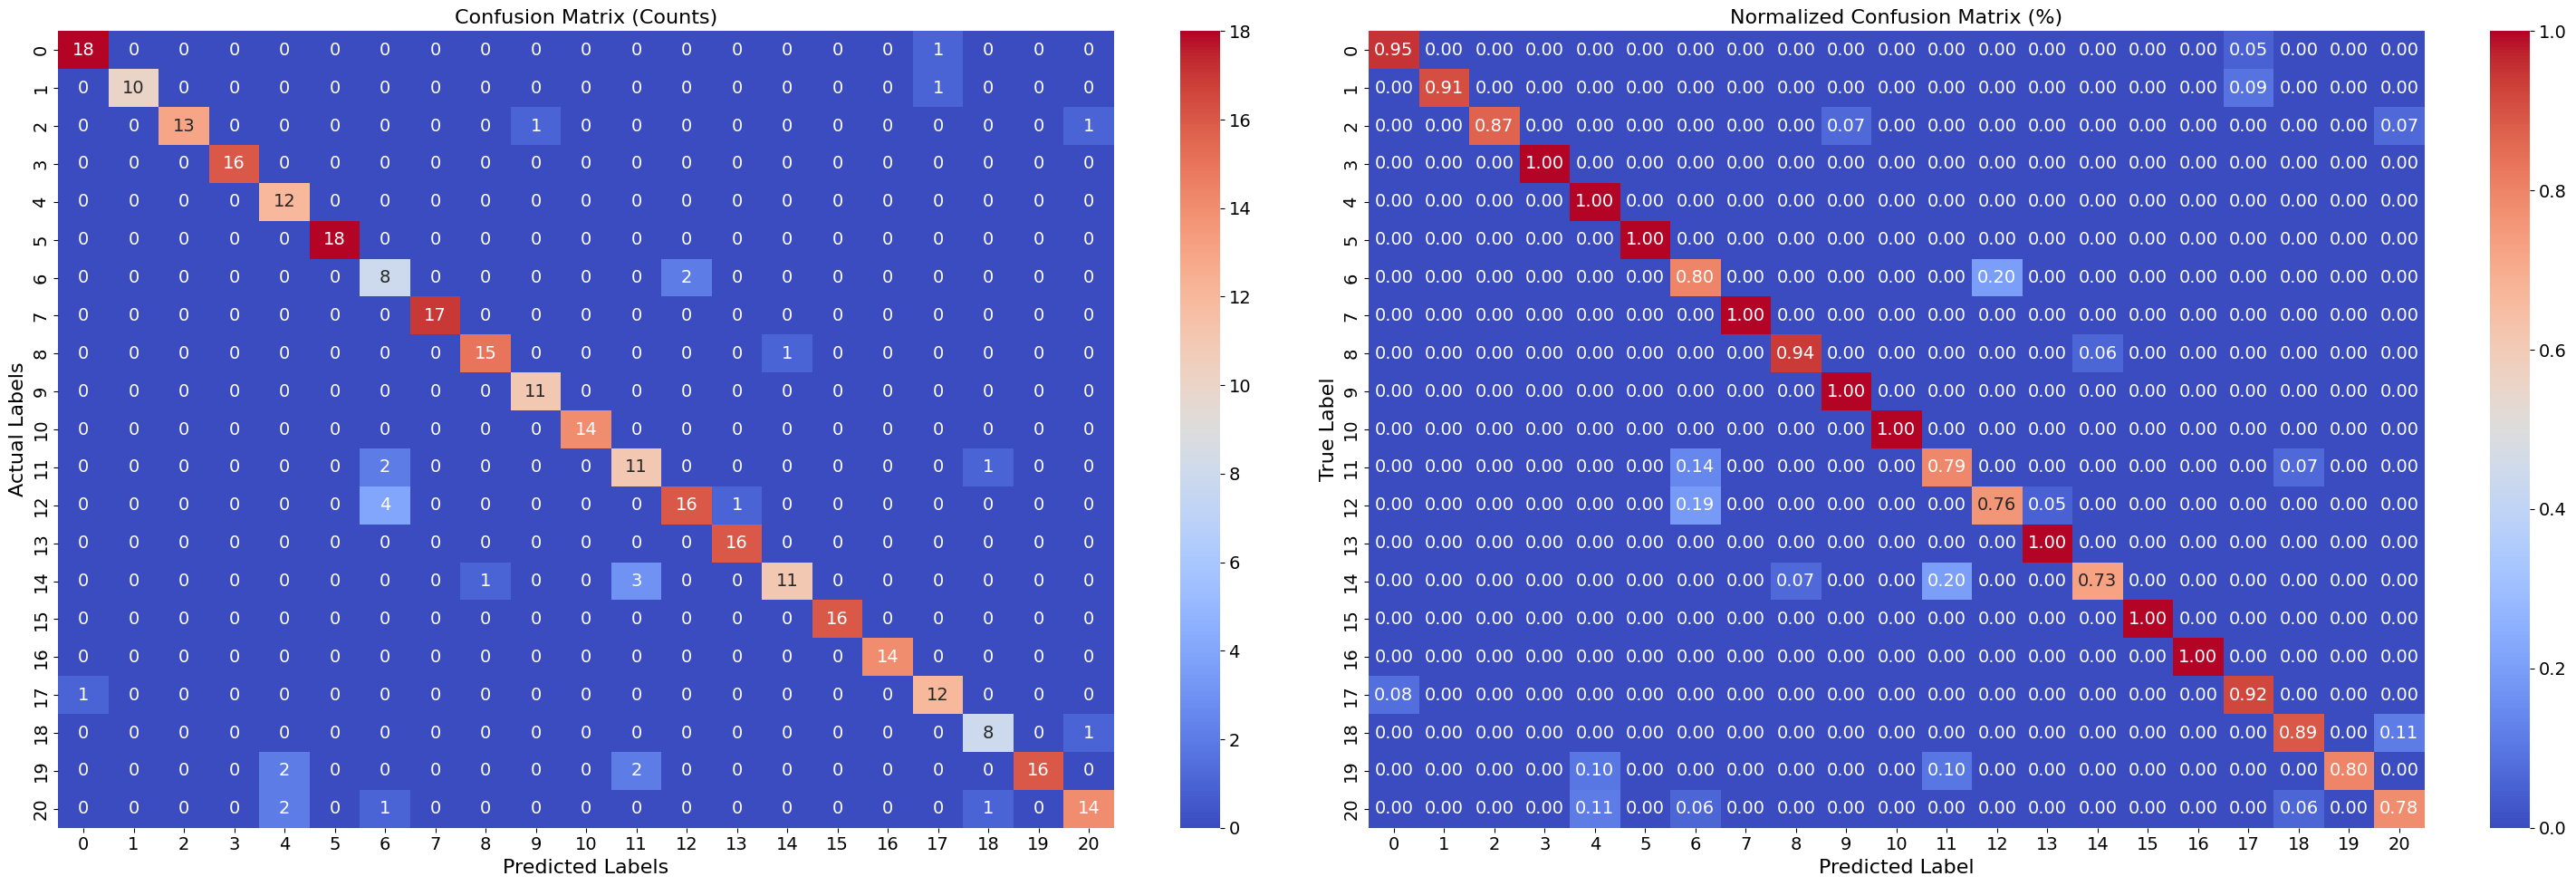

In [20]:
# Confusion Matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

# Sample based confusion matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', ax=ax1)
ax1.set_title("Confusion Matrix (Counts)")
ax1.set_xlabel("Predicted Labels")
ax1.set_ylabel("Actual Labels")

# Normalized confusion matrix
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize w/ true labels
sns.heatmap(np.round(cm_normalized, 2), annot=True, fmt=".2f", cmap='coolwarm',
            vmin=0, vmax=1, ax=ax2)
ax2.set_title("Normalized Confusion Matrix (%)")
ax2.set_xlabel("Predicted Label")
ax2.set_ylabel("True Label")
plt.tight_layout()
plt.show()

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---
**Comments:** Modifying the network structure to replace the classification head to include just the 21 classes of UCMerced dataset and training just the head improved the results. We were able to obtain almost 91% classification accuracy, 92% precision and 91% recall scores i.e. approx 2% improvement in all score as compared to previous method of using just the learnt features and training on XGB classifier. In same way, the confusion between classes also decreased except for few classes which have similar appearances and image structures (or features), for example- class 6 ('denseresidential') vs class 12 ('mediumresidential').

---
---

</div>


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 16px;">

### **Task III: Fine-tuning the Pretrained Model – Retraining the Entire Network**  

</div>

In [21]:
## Step 1: Modify and Unfreeze the Network

# Load pre-trained ResNet Model
model = models.resnet18(weights="IMAGENET1K_V1")

# Replace final layer for 21-class classification
num_classes = 21
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Unfreeze ALL layers
for param in model.parameters():
    param.requires_grad = True  # All parameters will be updated

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [22]:
## Step 2: Training Setup

# Hyperparameters
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # All layers tuned: (smaller LR for full fine-tuning)
scheduler = ExponentialLR(optimizer, gamma=0.9)      # LR decay
criterion = nn.CrossEntropyLoss()


In [23]:
## Step 2 contd: Training the model

# Track losses and accuracy
train_losses, val_losses = [], []
best_val_loss = float('inf')
epochs = 25

# Training
for epoch in range(epochs):

    # Training Phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

# Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), top_path + '/best_model_full_finetuned.pth')

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/25 | Train Loss: 1.6305 | Val Loss: 0.5266
Epoch 2/25 | Train Loss: 0.2820 | Val Loss: 0.2290
Epoch 3/25 | Train Loss: 0.1048 | Val Loss: 0.1785
Epoch 4/25 | Train Loss: 0.0512 | Val Loss: 0.1492
Epoch 5/25 | Train Loss: 0.0324 | Val Loss: 0.1274
Epoch 6/25 | Train Loss: 0.0242 | Val Loss: 0.1185
Epoch 7/25 | Train Loss: 0.0225 | Val Loss: 0.1144
Epoch 8/25 | Train Loss: 0.0168 | Val Loss: 0.1066
Epoch 9/25 | Train Loss: 0.0189 | Val Loss: 0.1034
Epoch 10/25 | Train Loss: 0.0134 | Val Loss: 0.1031
Epoch 11/25 | Train Loss: 0.0122 | Val Loss: 0.0959
Epoch 12/25 | Train Loss: 0.0117 | Val Loss: 0.0911
Epoch 13/25 | Train Loss: 0.0094 | Val Loss: 0.0942
Epoch 14/25 | Train Loss: 0.0090 | Val Loss: 0.0942
Epoch 15/25 | Train Loss: 0.0081 | Val Loss: 0.0920
Epoch 16/25 | Train Loss: 0.0080 | Val Loss: 0.0899
Epoch 17/25 | Train Loss: 0.0084 | Val Loss: 0.0875
Epoch 18/25 | Train Loss: 0.0076 | Val Loss: 0.0892
Epoch 19/25 | Train Loss: 0.0067 | Val Loss: 0.0878
Epoch 20/25 | Train L

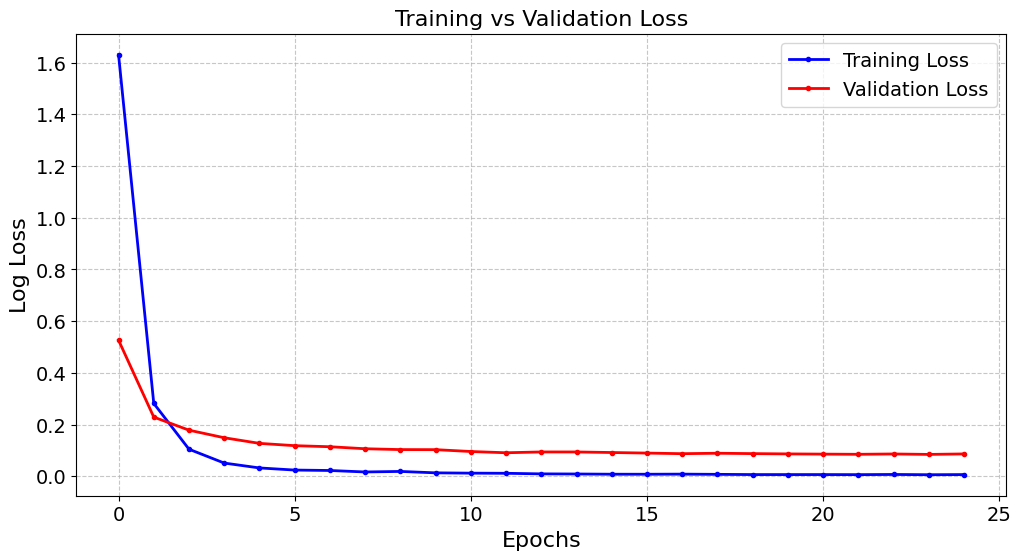

In [24]:
# Plot training/validation losses

# Loss curve plot

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2, marker = 'o', markersize = 3)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2, marker = 'o', markersize = 3)
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

In [25]:
# Load best model

model.load_state_dict(torch.load(top_path + '/best_model_full_finetuned.pth'))
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9587
Precision: 0.9633
Recall: 0.9587
F1-Score: 0.9597


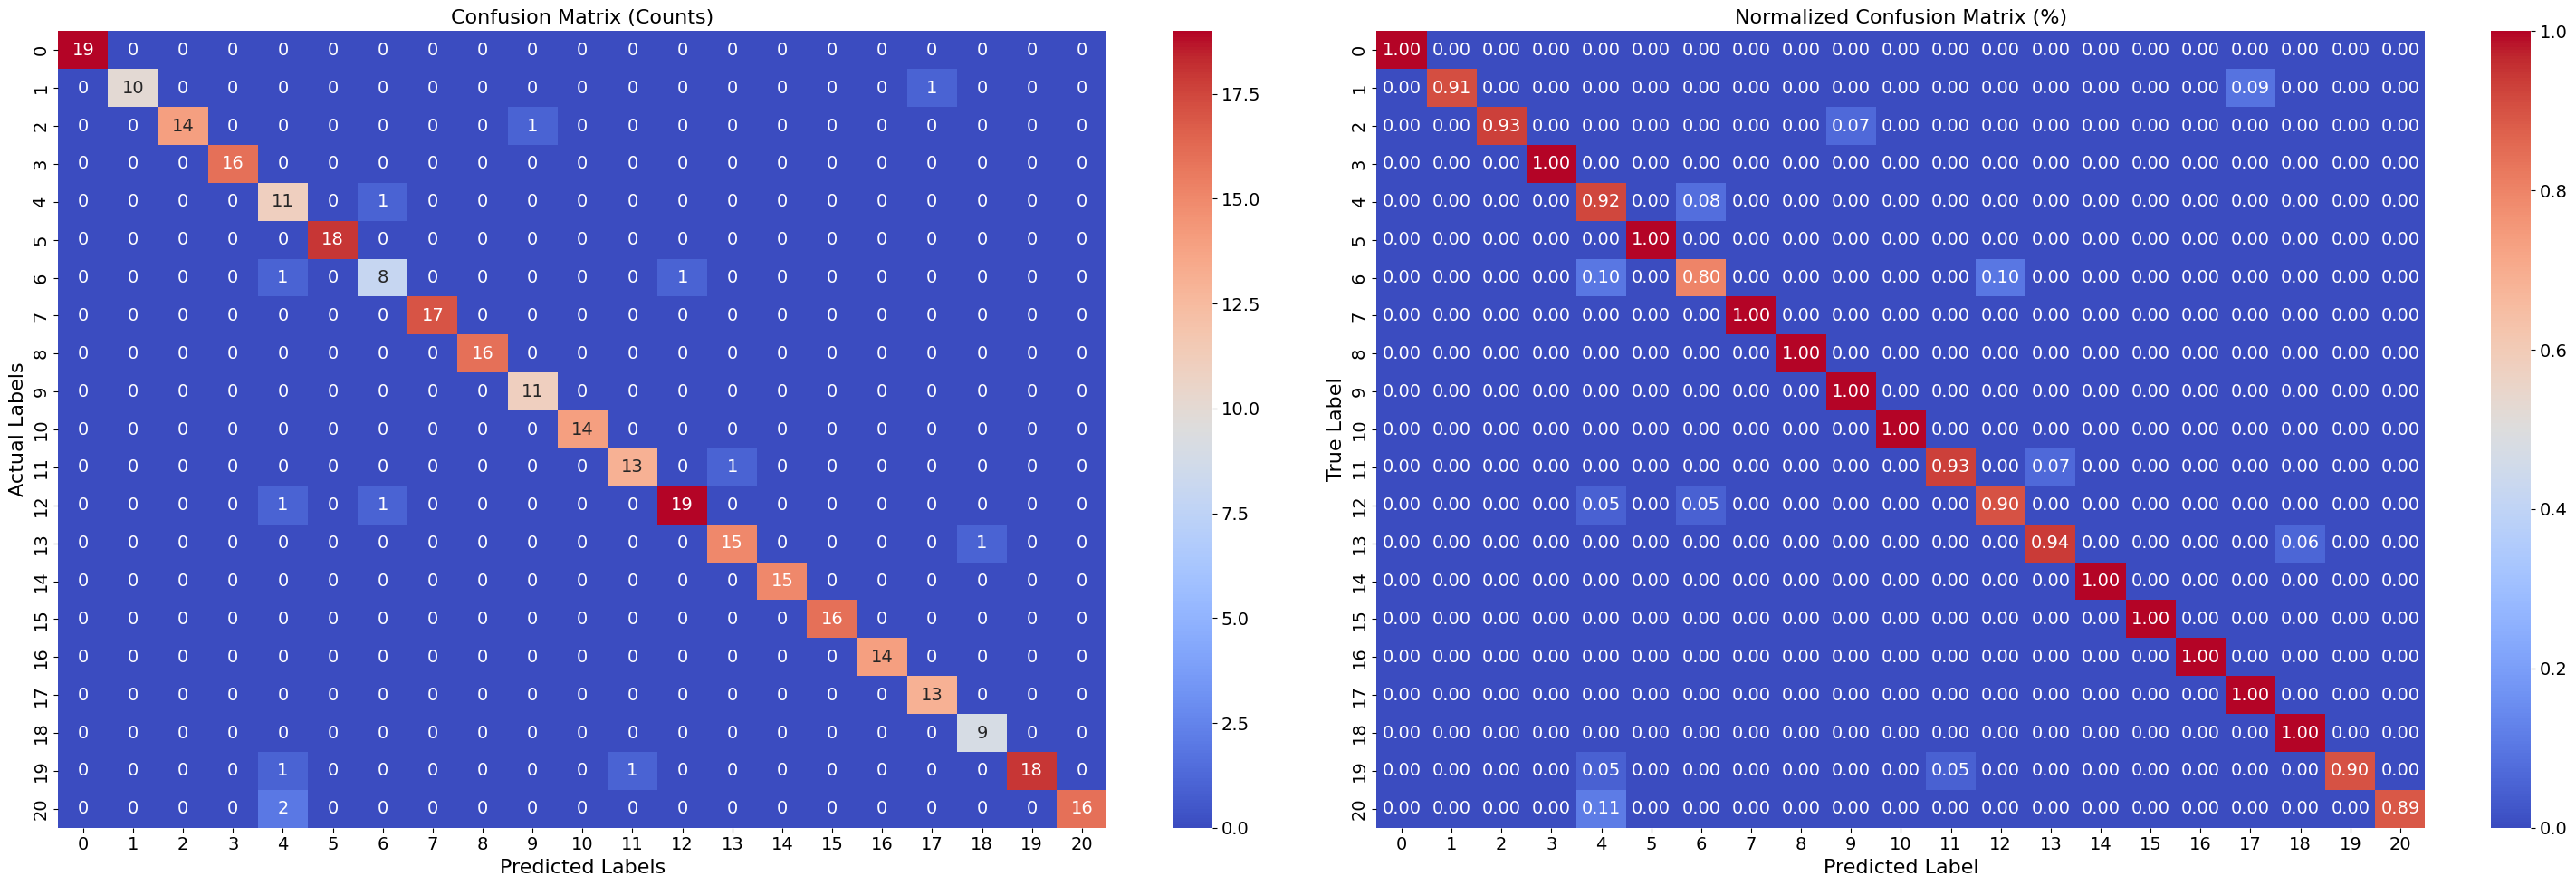

In [26]:
## Confusion Matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

# Sample based confusion matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', ax=ax1)
ax1.set_title("Confusion Matrix (Counts)")
ax1.set_xlabel("Predicted Labels")
ax1.set_ylabel("Actual Labels")

# Normalized confusion matrix
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize w/ true labels
sns.heatmap(np.round(cm_normalized, 2), annot=True, fmt=".2f", cmap='coolwarm',
            vmin=0, vmax=1, ax=ax2)
ax2.set_title("Normalized Confusion Matrix (%)")
ax2.set_xlabel("Predicted Label")
ax2.set_ylabel("True Label")
plt.tight_layout()
plt.show()

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---
**Comments:** Finally, fine-tuning the entire ResNet18 model with the UCMerced dataset and updating the feature representation of the model to suit this dataset produced significant improvements- approx. 96% classification accuracy, 96% precision and 96% recall scores. Almost all the classes were classified correctly with very few inter-class confusions as seen in the confusion matrix. Even those classes which were mostly confused by our previous models i.e. class 6 ('denseresidential') vs class 12 ('mediumresidential') were differentiated almost perfectly. Thus, this tuning method significantly adapted the model to our dataset.  

---
---

</div>
